## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and EMNIST dataset

In [1]:
%load_ext tensorboard

In [2]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [3]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [4]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [5]:
tf.__version__

'2.1.0'

In [6]:
# Hyperparameters
batch_size = 50
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

#### Load EMNIST dataset

In [7]:
import utils
import json

In [8]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/ubuntu/fed-learn-experiment/utils.py'>

In [9]:
FEMNIST_PATH = "./leaf/data/femnist/data/train/"
FEMNIST_TEST_PATH = "./leaf/data/femnist/data/test/"

what's the number after all_data_(num)? Thought it was a label but there are every class in one json file...

In [10]:
files = []
for i in range(0, 63):
    files.append(FEMNIST_PATH + utils.get_train_data_from_filename(i))

In [11]:
X, Y, users = utils.get_data(files)

(1/63) processing: ./leaf/data/femnist/data/train/all_data_0_niid_0_keep_10_train_9.json
(2/63) processing: ./leaf/data/femnist/data/train/all_data_1_niid_0_keep_10_train_9.json
(3/63) processing: ./leaf/data/femnist/data/train/all_data_2_niid_0_keep_10_train_9.json
(4/63) processing: ./leaf/data/femnist/data/train/all_data_3_niid_0_keep_10_train_9.json
(5/63) processing: ./leaf/data/femnist/data/train/all_data_4_niid_0_keep_10_train_9.json
(6/63) processing: ./leaf/data/femnist/data/train/all_data_5_niid_0_keep_10_train_9.json
(7/63) processing: ./leaf/data/femnist/data/train/all_data_6_niid_0_keep_10_train_9.json
(8/63) processing: ./leaf/data/femnist/data/train/all_data_7_niid_0_keep_10_train_9.json
(9/63) processing: ./leaf/data/femnist/data/train/all_data_8_niid_0_keep_10_train_9.json
(10/63) processing: ./leaf/data/femnist/data/train/all_data_9_niid_0_keep_10_train_9.json
(11/63) processing: ./leaf/data/femnist/data/train/all_data_10_niid_0_keep_10_train_9.json
(12/63) processing

In [12]:
test_files = []
for i in range(0, 6):
    test_files.append(FEMNIST_TEST_PATH + utils.get_test_data_from_filename(i))

In [13]:
X_test, Y_test, users_test = utils.get_data(test_files)

(1/6) processing: ./leaf/data/femnist/data/test/all_data_0_niid_0_keep_10_test_9.json
(2/6) processing: ./leaf/data/femnist/data/test/all_data_1_niid_0_keep_10_test_9.json
(3/6) processing: ./leaf/data/femnist/data/test/all_data_2_niid_0_keep_10_test_9.json
(4/6) processing: ./leaf/data/femnist/data/test/all_data_3_niid_0_keep_10_test_9.json
(5/6) processing: ./leaf/data/femnist/data/test/all_data_4_niid_0_keep_10_test_9.json
(6/6) processing: ./leaf/data/femnist/data/test/all_data_5_niid_0_keep_10_test_9.json


In [14]:
print("{} training data, {} test data".format(sum([n.shape[0] for n in X]), sum([n.shape[0] for n in X_test])))

722701 training data, 69393 test data


In [15]:
X_global, Y_global, local_data = \
utils.fl_parse(X=X, Y=Y, num_clients=20, min_num_global=200000, min_num_local=20000)

In [16]:
X_test = utils.serialize_data(X_test)
Y_test = utils.serialize_data(Y_test)

In [17]:
num_classes = len(np.unique(Y_test))

In [18]:
input_shape = X_global[0].shape

In [19]:
type(X_global)

numpy.ndarray

In [20]:
Y_global = keras.utils.to_categorical(Y_global, num_classes)

In [21]:
Y_global.shape

(200086, 62)

In [22]:
# convert class vectors to binary class matrices
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [23]:
for i in range(len(local_data)):
    local_data[i] = (local_data[i][0], keras.utils.to_categorical(local_data[i][1], num_classes))

### Define models and compile & fit function

In [24]:
def custom_model():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(600, activation='relu'))
    model.add(Dense(600, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [25]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [26]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [27]:
def fit_model_global(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(X_global, Y_global,
                      batch_size=100,
                      epochs=40,
                      shuffle=True, callbacks=[tensorboard_callback])

In [28]:
def fit_model_with_datasets(model, epochs, x_train, y_train):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=0.2,
                      shuffle=True, callbacks=[tensorboard_callback])

In [29]:
Y_global.shape

(200086, 62)

In [30]:
model1 = custom_model()
compile_model(model1)
fit_model_with_datasets(model1, 60, X_global, Y_global)

Training date and time : 
2020-04-08 05:09:27
Train on 160068 samples, validate on 40018 samples
Epoch 1/60
160068/160068 [==============================] - 14s 85us/sample - loss: 0.0156 - accuracy: 0.0855 - val_loss: 0.0157 - val_accuracy: 0.0839
Epoch 2/60
160068/160068 [==============================] - 13s 79us/sample - loss: 0.0155 - accuracy: 0.1430 - val_loss: 0.0157 - val_accuracy: 0.1094
Epoch 3/60
160068/160068 [==============================] - 12s 78us/sample - loss: 0.0153 - accuracy: 0.1788 - val_loss: 0.0157 - val_accuracy: 0.1153
Epoch 4/60
160068/160068 [==============================] - 13s 80us/sample - loss: 0.0152 - accuracy: 0.2048 - val_loss: 0.0156 - val_accuracy: 0.1330
Epoch 5/60
160068/160068 [==============================] - 13s 80us/sample - loss: 0.0149 - accuracy: 0.2343 - val_loss: 0.0154 - val_accuracy: 0.1612
Epoch 6/60
160068/160068 [==============================] - 14s 87us/sample - loss: 0.0146 - accuracy: 0.2716 - val_loss: 0.0153 - val_accuracy

Epoch 54/60
160068/160068 [==============================] - 13s 80us/sample - loss: 0.0087 - accuracy: 0.6119 - val_loss: 0.0097 - val_accuracy: 0.5583
Epoch 55/60
160068/160068 [==============================] - 15s 92us/sample - loss: 0.0086 - accuracy: 0.6136 - val_loss: 0.0096 - val_accuracy: 0.5653
Epoch 56/60
160068/160068 [==============================] - 13s 80us/sample - loss: 0.0086 - accuracy: 0.6159 - val_loss: 0.0096 - val_accuracy: 0.5666
Epoch 57/60
160068/160068 [==============================] - 13s 80us/sample - loss: 0.0086 - accuracy: 0.6171 - val_loss: 0.0094 - val_accuracy: 0.5746
Epoch 58/60
160068/160068 [==============================] - 13s 82us/sample - loss: 0.0085 - accuracy: 0.6189 - val_loss: 0.0096 - val_accuracy: 0.5658
Epoch 59/60
160068/160068 [==============================] - 13s 80us/sample - loss: 0.0085 - accuracy: 0.6204 - val_loss: 0.0096 - val_accuracy: 0.5662
Epoch 60/60
160068/160068 [==============================] - 12s 78us/sample - los

In [31]:
model_list = list()
for _ in range(10):
    model_list.append(tf.keras.models.clone_model(model1)) 
    model_list[_].set_weights(model1.get_weights())

In [32]:
# sort models according to similarity. We arbitrarily take the model1 as a "standard"
standard_model = tf.keras.models.clone_model(model1)
standard_model.set_weights(model_list[0].get_weights())

In [33]:
import semantic_drift

In [34]:
importlib.reload(semantic_drift)

<module 'semantic_drift' from '/home/ubuntu/fed-learn-experiment/semantic_drift.py'>

In [35]:
dist_list = [semantic_drift.l1_distance(standard_model, m) for m in model_list]

### Conduct transfer learning in local models using different datasets & epochs


In [36]:
local_data[0][1].shape

(20025, 62)

In [37]:
for i in range(len(model_list)):
    compile_model(model_list[i])
    fit_model_with_datasets(model_list[i], (i+1)*5, local_data[i][0], local_data[i][1])

Training date and time : 
2020-04-08 05:22:33
Train on 16020 samples, validate on 4005 samples
Epoch 1/5
16020/16020 [==============================] - 2s 107us/sample - loss: 0.0090 - accuracy: 0.5973 - val_loss: 0.0115 - val_accuracy: 0.4602
Epoch 2/5
16020/16020 [==============================] - 1s 82us/sample - loss: 0.0089 - accuracy: 0.5979 - val_loss: 0.0118 - val_accuracy: 0.4469
Epoch 3/5
16020/16020 [==============================] - 1s 80us/sample - loss: 0.0089 - accuracy: 0.6001 - val_loss: 0.0121 - val_accuracy: 0.4277
Epoch 4/5
16020/16020 [==============================] - 1s 82us/sample - loss: 0.0089 - accuracy: 0.6021 - val_loss: 0.0122 - val_accuracy: 0.4207
Epoch 5/5
16020/16020 [==============================] - 1s 80us/sample - loss: 0.0089 - accuracy: 0.6031 - val_loss: 0.0120 - val_accuracy: 0.4280
Training date and time : 
2020-04-08 05:22:40
Train on 16087 samples, validate on 4022 samples
Epoch 1/10
16087/16087 [==============================] - 2s 111us/sa

Epoch 3/25
16109/16109 [==============================] - 1s 86us/sample - loss: 0.0094 - accuracy: 0.5676 - val_loss: 0.0091 - val_accuracy: 0.5861
Epoch 4/25
16109/16109 [==============================] - 1s 82us/sample - loss: 0.0094 - accuracy: 0.5692 - val_loss: 0.0091 - val_accuracy: 0.5852
Epoch 5/25
16109/16109 [==============================] - 1s 81us/sample - loss: 0.0094 - accuracy: 0.5699 - val_loss: 0.0091 - val_accuracy: 0.5909
Epoch 6/25
16109/16109 [==============================] - 1s 86us/sample - loss: 0.0094 - accuracy: 0.5715 - val_loss: 0.0091 - val_accuracy: 0.5884
Epoch 7/25
16109/16109 [==============================] - 1s 85us/sample - loss: 0.0093 - accuracy: 0.5719 - val_loss: 0.0091 - val_accuracy: 0.5886
Epoch 8/25
16109/16109 [==============================] - 1s 82us/sample - loss: 0.0093 - accuracy: 0.5712 - val_loss: 0.0091 - val_accuracy: 0.5847
Epoch 9/25
16109/16109 [==============================] - 2s 97us/sample - loss: 0.0093 - accuracy: 0.5710

16220/16220 [==============================] - 2s 107us/sample - loss: 0.0093 - accuracy: 0.5745 - val_loss: 0.0089 - val_accuracy: 0.6023
Epoch 2/35
16220/16220 [==============================] - 1s 80us/sample - loss: 0.0092 - accuracy: 0.5774 - val_loss: 0.0089 - val_accuracy: 0.5996
Epoch 3/35
16220/16220 [==============================] - 1s 84us/sample - loss: 0.0092 - accuracy: 0.5775 - val_loss: 0.0088 - val_accuracy: 0.6050
Epoch 4/35
16220/16220 [==============================] - 1s 82us/sample - loss: 0.0092 - accuracy: 0.5806 - val_loss: 0.0089 - val_accuracy: 0.6058
Epoch 5/35
16220/16220 [==============================] - 1s 83us/sample - loss: 0.0092 - accuracy: 0.5801 - val_loss: 0.0089 - val_accuracy: 0.6021
Epoch 6/35
16220/16220 [==============================] - 1s 81us/sample - loss: 0.0091 - accuracy: 0.5816 - val_loss: 0.0088 - val_accuracy: 0.6097
Epoch 7/35
16220/16220 [==============================] - 1s 83us/sample - loss: 0.0091 - accuracy: 0.5828 - val_los

16275/16275 [==============================] - 1s 92us/sample - loss: 0.0095 - accuracy: 0.5642 - val_loss: 0.0098 - val_accuracy: 0.5498
Epoch 21/40
16275/16275 [==============================] - 1s 79us/sample - loss: 0.0095 - accuracy: 0.5653 - val_loss: 0.0099 - val_accuracy: 0.5453
Epoch 22/40
16275/16275 [==============================] - 1s 83us/sample - loss: 0.0095 - accuracy: 0.5668 - val_loss: 0.0098 - val_accuracy: 0.5478
Epoch 23/40
16275/16275 [==============================] - 1s 82us/sample - loss: 0.0095 - accuracy: 0.5665 - val_loss: 0.0098 - val_accuracy: 0.5495
Epoch 24/40
16275/16275 [==============================] - 1s 82us/sample - loss: 0.0095 - accuracy: 0.5667 - val_loss: 0.0098 - val_accuracy: 0.5525
Epoch 25/40
16275/16275 [==============================] - 2s 93us/sample - loss: 0.0095 - accuracy: 0.5661 - val_loss: 0.0098 - val_accuracy: 0.5500
Epoch 26/40
16275/16275 [==============================] - 2s 100us/sample - loss: 0.0095 - accuracy: 0.5681 - v

16106/16106 [==============================] - 1s 80us/sample - loss: 0.0087 - accuracy: 0.6136 - val_loss: 0.0080 - val_accuracy: 0.6496
Epoch 35/45
16106/16106 [==============================] - 1s 81us/sample - loss: 0.0087 - accuracy: 0.6136 - val_loss: 0.0080 - val_accuracy: 0.6518
Epoch 36/45
16106/16106 [==============================] - 1s 80us/sample - loss: 0.0087 - accuracy: 0.6138 - val_loss: 0.0080 - val_accuracy: 0.6499
Epoch 37/45
16106/16106 [==============================] - 1s 88us/sample - loss: 0.0087 - accuracy: 0.6160 - val_loss: 0.0079 - val_accuracy: 0.6511
Epoch 38/45
16106/16106 [==============================] - 1s 81us/sample - loss: 0.0087 - accuracy: 0.6147 - val_loss: 0.0079 - val_accuracy: 0.6566
Epoch 39/45
16106/16106 [==============================] - 1s 82us/sample - loss: 0.0087 - accuracy: 0.6165 - val_loss: 0.0079 - val_accuracy: 0.6566
Epoch 40/45
16106/16106 [==============================] - 1s 79us/sample - loss: 0.0087 - accuracy: 0.6160 - va

16076/16076 [==============================] - 1s 83us/sample - loss: 0.0085 - accuracy: 0.6167 - val_loss: 0.0108 - val_accuracy: 0.4978
Epoch 44/50
16076/16076 [==============================] - 1s 84us/sample - loss: 0.0085 - accuracy: 0.6176 - val_loss: 0.0111 - val_accuracy: 0.4833
Epoch 45/50
16076/16076 [==============================] - 1s 82us/sample - loss: 0.0085 - accuracy: 0.6172 - val_loss: 0.0108 - val_accuracy: 0.4988
Epoch 46/50
16076/16076 [==============================] - 1s 82us/sample - loss: 0.0085 - accuracy: 0.6192 - val_loss: 0.0111 - val_accuracy: 0.4851
Epoch 47/50
16076/16076 [==============================] - 1s 79us/sample - loss: 0.0085 - accuracy: 0.6179 - val_loss: 0.0110 - val_accuracy: 0.4883
Epoch 48/50
16076/16076 [==============================] - 1s 78us/sample - loss: 0.0085 - accuracy: 0.6192 - val_loss: 0.0111 - val_accuracy: 0.4813
Epoch 49/50
16076/16076 [==============================] - 1s 82us/sample - loss: 0.0085 - accuracy: 0.6186 - va

### Let's see how these models are different from each other, compared to the base model(before training)


In [38]:
model_list.sort(key=lambda m : semantic_drift.l2_distance(model1, m))

In [39]:
theta_list = list(np.arange(0, 1.05, 0.05))

In [40]:
agg_weights_list_per_pi = list()
for model_comp in model_list:
    weights = [model1.get_weights(), model_comp.get_weights()]
    agg_weights_list = list()
    for theta in theta_list:
        agg_weights = list()
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        agg_weights_list.append(agg_weights)
    agg_weights_list_per_pi.append(agg_weights_list)

In [41]:
dist_list = [semantic_drift.l2_distance(standard_model, m) for m in model_list]

In [42]:
dist_list

[2.4901943232478577e-08,
 8.552184075957508e-08,
 1.1138670458294076e-07,
 1.9842548400837185e-07,
 3.122630650372902e-07,
 3.8301490482357875e-07,
 6.656196983349213e-07,
 7.014420164946945e-07,
 8.524899299672931e-07,
 9.079676970388701e-07]

In [43]:
X, Y = np.meshgrid(np.array(theta_list), np.array(sorted(dist_list)))

In [44]:
Z = np.zeros(X.shape)

In [45]:
i = 0
for agg_weights_list in agg_weights_list_per_pi:
    j = 0
    for agg_weights in agg_weights_list:
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights)
        compile_model(aggr_model)
        score = aggr_model.evaluate(X_test, Y_test);
        Z[i][j] = score[0]
        j += 1
    i += 1

69393/69393 [==============================] - 4s 61us/sample - loss: 0.0089 - accuracy: 0.6010


69393/69393 [==============================] - 4s 59us/sample - loss: 0.0089 - accuracy: 0.6020


69393/69393 [==============================] - 4s 62us/sample - loss: 0.0092 - accuracy: 0.5810


In [46]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

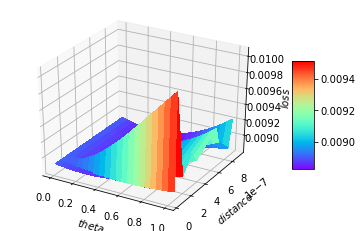

In [47]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.rainbow,
                       linewidth=0, antialiased=False)
ax.set_xlabel('$theta$')
ax.set_ylabel('$distance$')
ax.set_zlabel('$loss$')
# Customize the z axis.
# ax.set_xlim(0.051, 0.054)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# ax.view_init(0, 180)
# ax.view_init(0, 0)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('fig1.png')
plt.show()